In [1]:
    # !pip install opendatasets librosa numpy torch matplotlib

In [2]:
# import opendatasets as od
# import os

# # Download the dataset
# dataset_url = 'https://www.kaggle.com/datasets/mathurinache/the-lj-speech-dataset'
# data_dir = './LJSpeech-1.1'

# if not os.path.exists(data_dir):
#     od.download(dataset_url)


In [3]:
import os
import librosa
import numpy as np
import torch

# Path to the downloaded audio files
audio_files_path = r"C:\Users\Imman\Documents\Internship\Refonte_Paribas\Assignment_2\LJSpeech-1.1\wavs"
audio_files = [os.path.join(audio_files_path, f) for f in os.listdir(audio_files_path) if f.endswith('.wav')]

# def process_audio(file_path):
#     y, sr = librosa.load(file_path, sr=22050)
#     mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=80)  # Changed to 80 Mel bins
#     mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
#     return mel_spec_db

def process_audio(file_path, duration=None):
    y, sr = librosa.load(file_path, sr=22050, duration=duration)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=100)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db


mel_specs = [process_audio(file) for file in audio_files[:100]]  # Limit to 100 files for now

In [4]:
# Split the data: 60% for training and 40% for testing
split_idx = int(len(mel_specs) * 0.95)
train_mel_specs = mel_specs[:split_idx]
test_mel_specs = mel_specs[split_idx:]


In [5]:
def create_batches(data, batch_size=2, block_size=100):
    data_batches = []
    for i in range(0, len(data), batch_size):
        batch = data[i:i+batch_size]
        if len(batch) == batch_size:
            data_batches.append(batch)
    return data_batches

mel_batches = create_batches(mel_specs)
train_batches = create_batches(train_mel_specs)
test_batches = create_batches(test_mel_specs)

In [6]:
import torch
def prepare_data(batches, block_size=100):
    inputs, targets = [], []
    for batch in batches:
        for mel_spec in batch:
            mel_spec = (mel_spec - np.mean(mel_spec)) / np.std(mel_spec)  # Normalize
            for i in range(0, mel_spec.shape[1] - block_size, block_size):
                input_seq = mel_spec[:, i:i+block_size]
                target_seq = mel_spec[:, i+1:i+block_size+1]
                inputs.append(input_seq)
                targets.append(target_seq)
                
    inputs = np.array(inputs)
    targets = np.array(targets)
    
    inputs_tensor = torch.tensor(inputs, dtype=torch.float32)
    targets_tensor = torch.tensor(targets, dtype=torch.float32)
    
    return inputs_tensor, targets_tensor

train_inputs, train_targets = prepare_data(train_batches)
test_inputs, test_targets = prepare_data(test_batches)
mel_specs_inputs, mel_specs_targets = prepare_data(mel_batches)

In [7]:
import torch.nn as nn

class ImprovedRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=3):
        super(ImprovedRNN, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.3)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(num_layers, x.size(0), hidden_size).to(x.device)
        c0 = torch.zeros(num_layers, x.size(0), hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out)
        return out

input_size = 100  # number of Mel bins (changed to 80)
hidden_size = 256  # Increased hidden size
output_size = 100  # number of Mel bins (changed to 80)
num_layers = 3  # Added more layers

model = ImprovedRNN(input_size, hidden_size, output_size, num_layers)

In [8]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Assuming model, train_inputs, train_targets, test_inputs, and test_targets are defined

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

epochs = 100
batch_size = 16
patience = 5  # Early stopping patience

# Create DataLoaders
train_dataset = TensorDataset(train_inputs, train_targets)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# train_mel = TensorDataset

test_dataset = TensorDataset(test_inputs, test_targets)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

def train_model(model, train_loader, test_loader, epochs, patience, verbose=True):
    model.train()
    best_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for batch_inputs, batch_targets in train_loader:
            optimizer.zero_grad()
            output = model(batch_inputs)
            loss = criterion(output, batch_targets)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_epoch_loss = epoch_loss / len(train_loader)
        if verbose:
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {avg_epoch_loss:.4f}')

        # Validation step
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for val_inputs, val_targets in test_loader:
                val_output = model(val_inputs)
                val_loss += criterion(val_output, val_targets).item()

        avg_val_loss = val_loss / len(test_loader)
        if verbose:
            print(f'Validation Loss: {avg_val_loss:.4f}')
        scheduler.step(avg_val_loss)

        # Early stopping and model checkpointing
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                if verbose:
                    print("Early stopping")
                break

    # Load best model state
    if best_model_state:
        model.load_state_dict(best_model_state)

train_model(model, train_loader, test_loader, epochs, patience)


Epoch [1/100], Loss: 0.8675
Validation Loss: 0.7111
Epoch [2/100], Loss: 0.6505
Validation Loss: 0.5576
Epoch [3/100], Loss: 0.5187
Validation Loss: 0.4518
Epoch [4/100], Loss: 0.4305
Validation Loss: 0.3819
Epoch [5/100], Loss: 0.3694
Validation Loss: 0.3236
Epoch [6/100], Loss: 0.3171
Validation Loss: 0.2775
Epoch [7/100], Loss: 0.2687
Validation Loss: 0.2305
Epoch [8/100], Loss: 0.2302
Validation Loss: 0.2020
Epoch [9/100], Loss: 0.2046
Validation Loss: 0.1780
Epoch [10/100], Loss: 0.1870
Validation Loss: 0.1634
Epoch [11/100], Loss: 0.1717
Validation Loss: 0.1490
Epoch [12/100], Loss: 0.1589
Validation Loss: 0.1381
Epoch [13/100], Loss: 0.1477
Validation Loss: 0.1275
Epoch [14/100], Loss: 0.1385
Validation Loss: 0.1193
Epoch [15/100], Loss: 0.1313
Validation Loss: 0.1112
Epoch [16/100], Loss: 0.1248
Validation Loss: 0.1060
Epoch [17/100], Loss: 0.1193
Validation Loss: 0.0984
Epoch [18/100], Loss: 0.1143
Validation Loss: 0.0934
Epoch [19/100], Loss: 0.1102
Validation Loss: 0.0890
Ep

In [9]:
def MAPE(actual, prediction):
    """
    Calculate the Mean Absolute Percentage Error (MAPE) between two lists.
    
    MAPE is a measure of prediction accuracy of a forecasting method in statistics,
    specifically trending markets. It expresses accuracy as a percentage, and is defined
    by the formula: MAPE = (1/n) * Σ(|actual - prediction| / |actual|) * 100
    
    Parameters:
    - actual (list or array-like): The actual data points. Must be 1-dimensional and 
      the same length as 'prediction'.
    - prediction (list or array-like): The predicted data points, which correspond to 
      'actual'. Must be 1-dimensional and the same length as 'actual'.

    Returns:
    - float: The mean absolute percentage error (MAPE) as a percentage, rounded to two decimal places.
    """
    actual, prediction = np.array(actual), np.array(prediction)
    if np.any(actual == 0):
        raise ValueError("MAPE is undefined for zero actual values because of division by zero")
    mape = np.mean(np.abs((actual - prediction) / actual)) * 100
    return round(mape, 2)

In [10]:
model.eval()  # Set the model to evaluation mode

with torch.no_grad():  # Disable gradient calculation for evaluation
    test_outputs = model(test_inputs)
    mse = criterion(test_outputs, test_targets).item()
    print(f'Mean Squared Error on test data: {mse:.4f}')


Mean Squared Error on test data: 0.0377


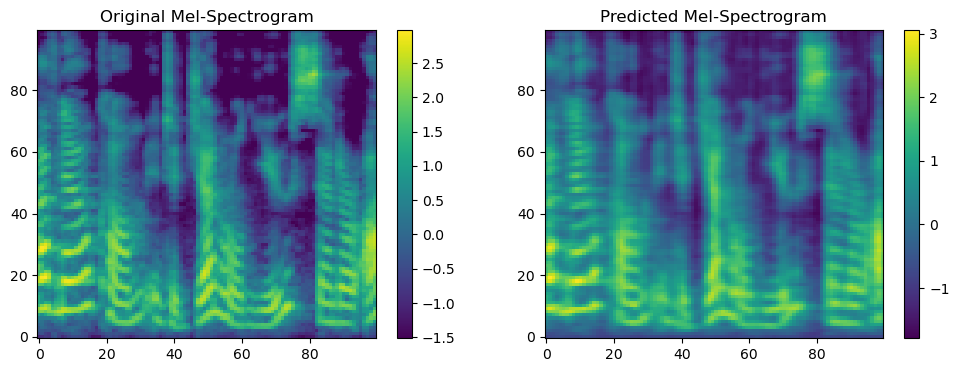

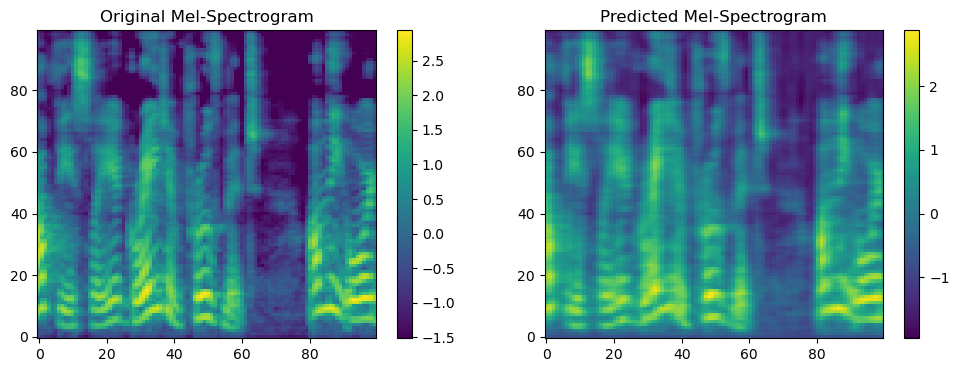

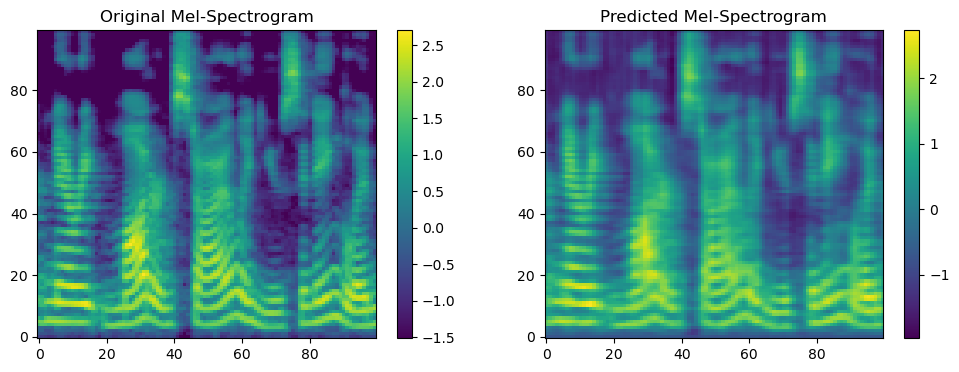

In [11]:
    import matplotlib.pyplot as plt
    
    num_examples = 3
    for i in range(num_examples):
        plt.figure(figsize=(12, 4))
    
        plt.subplot(1, 2, 1)
        plt.title('Original Mel-Spectrogram')
        plt.imshow(test_targets[i].cpu().numpy(), aspect='auto', origin='lower')
        plt.colorbar()
    
        plt.subplot(1, 2, 2)
        plt.title('Predicted Mel-Spectrogram')
        plt.imshow(test_outputs[i].cpu().numpy(), aspect='auto', origin='lower')
        plt.colorbar()
    
        plt.show()


In [12]:
test_targets

tensor([[[-1.0200e+00, -8.6786e-01, -7.3676e-01,  ..., -3.9289e-01,
          -6.1010e-01, -6.8602e-01],
         [-5.2054e-01, -3.6948e-01, -6.5441e-01,  ..., -2.0995e-03,
          -3.4514e-01, -4.3061e-01],
         [-2.4452e-01, -2.7998e-01, -3.7681e-01,  ...,  2.8323e-01,
          -2.1210e-01, -2.4524e-01],
         ...,
         [-1.5154e+00, -1.5154e+00, -1.3457e+00,  ..., -6.4406e-01,
          -3.7010e-01, -4.7908e-01],
         [-1.5154e+00, -1.2490e+00, -9.5516e-01,  ..., -1.0762e+00,
          -7.1767e-01, -7.2232e-01],
         [-1.5154e+00, -1.4854e+00, -1.1481e+00,  ..., -1.5154e+00,
          -1.3391e+00, -1.0826e+00]],

        [[-5.7995e-01, -6.5148e-01, -7.9626e-01,  ..., -4.5817e-01,
          -4.7471e-01, -5.8036e-01],
         [-3.0021e-01, -2.4691e-01, -4.4266e-01,  ..., -2.1445e-01,
          -1.9181e-01, -2.9863e-01],
         [-4.2166e-01, -3.3503e-01, -4.1480e-01,  ...,  4.7010e-02,
          -1.1872e-02, -3.7048e-01],
         ...,
         [-6.9250e-01, -1

Using cache found in C:\Users\Imman/.cache\torch\hub\nvidia_DeepLearningExamples_torchhub
C:\Users\Imman/.cache\torch\hub\nvidia_DeepLearningExamples_torchhub\PyTorch\Classification\ConvNets\image_classification\models\common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
C:\Users\Imman/.cache\torch\hub\nvidia_DeepLearningExamples_torchhub\PyTorch\Classification\ConvNets\image_classification\models\efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
C:\Users\Imman\Documents\anaconda3\Lib\site-packages\torch\nn\utils\weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


Mean Squared Error on test data: 0.0377


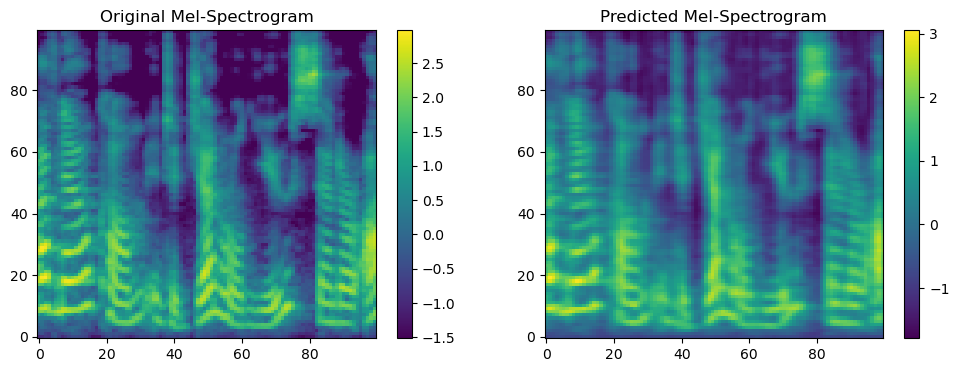

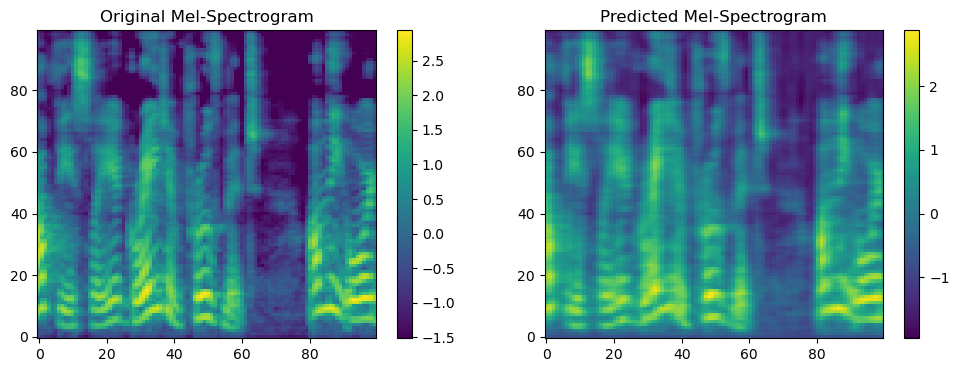

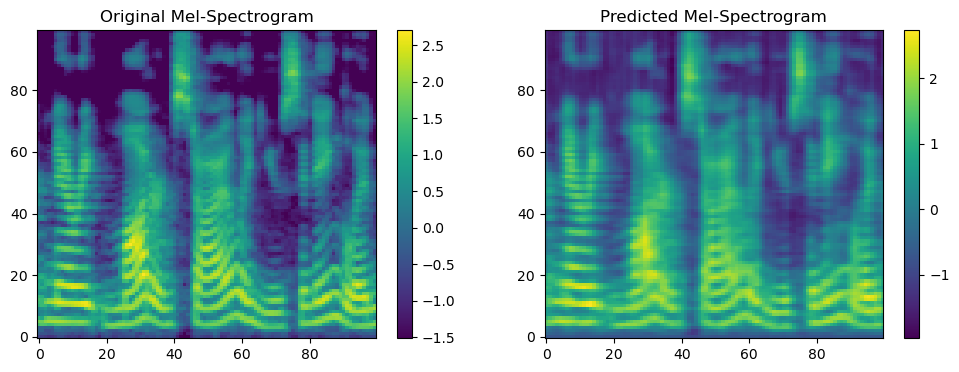

In [13]:
import torch
import torchaudio
from scipy.io.wavfile import write
import matplotlib.pyplot as plt

# Load the pretrained WaveGlow model
waveglow = torch.hub.load('nvidia/DeepLearningExamples:torchhub', 'nvidia_waveglow')
waveglow = waveglow.remove_weightnorm(waveglow)
waveglow = waveglow.cuda().eval()

# Function to convert Mel-spectrogram to audio
def mel_to_audio(mel_spec, waveglow_model, sigma=1.0):
    mel_spec = torch.tensor(mel_spec).unsqueeze(0).cuda()
    with torch.no_grad():
        audio = waveglow_model.infer(mel_spec, sigma=sigma)
    audio = audio.cpu().numpy()
    return audio

# Evaluate model and convert Mel-spectrograms to audio
model.eval()  # Set the model to evaluation mode

with torch.no_grad():  # Disable gradient calculation for evaluation
    test_outputs = model(test_inputs)
    mse = criterion(test_outputs, test_targets).item()
    print(f'Mean Squared Error on test data: {mse:.4f}')

    # Convert a few Mel-spectrograms to audio for listening
    num_examples = 3
    for i in range(num_examples):
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.title('Original Mel-Spectrogram')
        plt.imshow(test_targets[i].cpu().numpy(), aspect='auto', origin='lower')
        plt.colorbar()

        plt.subplot(1, 2, 2)
        plt.title('Predicted Mel-Spectrogram')
        plt.imshow(test_outputs[i].cpu().numpy(), aspect='auto', origin='lower')
        plt.colorbar()

        plt.show()

        # # Convert predicted Mel-spectrogram to audio
        # predicted_mel_spec = test_outputs[i].cpu().numpy()
        # generated_audio = mel_to_audio(predicted_mel_spec, waveglow)
        
        # # Save the generated audio to a file
        # output_path = f'generated_audio_{i}.wav'
        # write(output_path, 22050, generated_audio.squeeze())
        # print(f'Generated audio saved to {output_path}')

In [14]:
import librosa
import numpy as np
import soundfile as sf

def mel_to_audio(mel_spec_db, sr=22050, n_fft=2048, hop_length=512, n_mels=100):
    # Convert dB to power
    mel_spec = librosa.db_to_power(mel_spec_db)
    
    # Inverse Mel spectrogram to linear spectrogram
    mel_basis = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_mels)
    inv_mel_basis = np.linalg.pinv(mel_basis)
    linear_spec = np.dot(inv_mel_basis, mel_spec)
    
    # Reconstruct the audio using the Griffin-Lim algorithm
    audio = librosa.griffinlim(linear_spec, n_iter=32, hop_length=hop_length)
    
    return audio

# Assuming mel_specs is a list of Mel spectrograms
# Select a Mel spectrogram to convert
mel_spec_db = test_outputs[5]  # Example, convert the first Mel spectrogram
# mel_spec_db = test_targets[0]  # Example, convert the first Mel spectrogram

# Convert Mel spectrogram back to audio
audio = mel_to_audio(mel_spec_db)

# Save the audio to a file
output_path = 'output.wav'
sf.write(output_path, audio, 22050)
print(f'Audio file saved to {output_path}')


Audio file saved to output.wav
